# Goal: Create machine learning model that will classify wheat pictures based on health (healthy or not)

## Step 0: Loading libraries

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm
from tqdm.notebook import tqdm
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random
import sys
import pandas as pd


### Printing versions:

In [22]:
print('System Version:', sys.version)
print('PyTorch version', torch.__version__)
print('Torchvision version', torchvision.__version__)
print('Numpy version', np.__version__)
print('Pandas version', pd.__version__)

System Version: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
PyTorch version 2.8.0+cu126
Torchvision version 0.23.0+cu126
Numpy version 2.0.2
Pandas version 2.2.2


### Set device:

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


## Step 1: Pytorch Dataset (and Dataloader)

### Step 1.1. Dataset

In [24]:
class WheatBinaryDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(data_dir, transform=transform)
        # Identify the index for 'Healthy'
        self.healthy_idx = self.data.class_to_idx.get('Healthy', None)
        if self.healthy_idx is None:
            print("Warning: 'Healthy' folder not found. Check your folder names!")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img, label = self.data[idx]
        # Binary: 0 if Healthy, 1 if any disease
        binary_label = 0 if label == self.healthy_idx else 1
        return img, binary_label




### Step 1.2. Transformation

In [25]:
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225]
    )
])

### Step 1.3. Dataset & Dataloader

In [26]:
train_folder = '/kaggle/input/wheat-plant-diseases/data/train'
val_folder   = '/kaggle/input/wheat-plant-diseases/data/valid'

train_dataset = WheatBinaryDataset(train_folder, train_transform)
val_dataset   = WheatBinaryDataset(val_folder, train_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)

## Step 2. Pytorch Model

In [27]:
class WheatBinaryClassifier(nn.Module):
    def __init__(self):
        super().__init__()

        self.backbone = timm.create_model(
            'efficientnet_b0',
            pretrained=True,
            num_classes=0  
        )

        self.classifier = nn.Linear(1280, 1)

    def forward(self, x):
        x = self.backbone(x)  
        x = self.classifier(x)
        return x





### Step 2.1. Model initialisation

In [28]:
model = WheatBinaryClassifier().to(device)


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

## Step 3: Model training

### Step 3.1. Loss & Optimizer

In [29]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

### Step 3.2. One training loop

In [30]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0

    for images, labels in tqdm(loader, desc="Training", leave=False):
        images = images.to(device)
        labels = labels.to(device).float()

        optimizer.zero_grad()
        outputs = model(images).squeeze(1)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    return running_loss / len(loader)


### Step 3.3. Model Validation

In [31]:
def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Validating", leave=False):
            images = images.to(device)
            labels = labels.to(device).float()

            outputs = model(images).squeeze(1)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            preds = (torch.sigmoid(outputs) > 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return running_loss / len(loader), correct / total


### Step 3.4. Main training loop

In [32]:
epochs = 5

for epoch in range(epochs):
    train_loss = train_one_epoch(
        model, train_loader, criterion, optimizer, device
    )
    val_loss, val_acc = validate(
        model, val_loader, criterion, device
    )

    print(f"Epoch [{epoch+1}/{epochs}]")
    print(f"Train Loss: {train_loss:.4f} | "
          f"Val Loss: {val_loss:.4f} | "
          f"Val Acc: {val_acc:.2%}")
    print("-" * 30)


Training:   0%|          | 0/410 [00:00<?, ?it/s]

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1/5]
Train Loss: 0.1664 | Val Loss: 0.0401 | Val Acc: 98.67%
------------------------------


Training:   0%|          | 0/410 [00:00<?, ?it/s]

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [2/5]
Train Loss: 0.0264 | Val Loss: 0.0270 | Val Acc: 99.33%
------------------------------


Training:   0%|          | 0/410 [00:00<?, ?it/s]

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [3/5]
Train Loss: 0.0128 | Val Loss: 0.0255 | Val Acc: 99.33%
------------------------------


Training:   0%|          | 0/410 [00:00<?, ?it/s]

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [4/5]
Train Loss: 0.0075 | Val Loss: 0.0368 | Val Acc: 99.00%
------------------------------


Training:   0%|          | 0/410 [00:00<?, ?it/s]

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [5/5]
Train Loss: 0.0071 | Val Loss: 0.0238 | Val Acc: 99.33%
------------------------------


## Step 4: Post training

### Step 4.1. Preprocessing image

In [33]:
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.485, 0.456, 0.406],
            [0.229, 0.224, 0.225]
        )
    ])

    image = Image.open(image_path).convert("RGB")
    return image, transform(image).unsqueeze(0)


### Step 4.1. Prediction

In [34]:
def predict_binary(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        output = model(image_tensor.to(device))
        prob_disease = torch.sigmoid(output).item()

    return [1 - prob_disease, prob_disease]


### Step 4.2. Visualization

In [ ]:
def visualize_wheat_prediction(original_image, probabilities):
    class_names = ['Zdravo (Healthy)', 'Bolesno (Disease)']
    
    fig, axarr = plt.subplots(1, 2, figsize=(12, 5))
    
    # show image
    axarr[0].imshow(original_image)
    axarr[0].axis("off")
    axarr[0].set_title("Originalni snimak pšenice")
    
    # prob graph
    colors = ['green', 'red']
    axarr[1].barh(class_names, probabilities, color=colors)
    axarr[1].set_xlabel("Verovatnoća (0.0 - 1.0)")
    axarr[1].set_title("Rezultat analize")
    axarr[1].set_xlim(0, 1)

    # bar percentage
    for i, v in enumerate(probabilities):
        axarr[1].text(v + 0.01, i, f"{v:.2%}", color='black', fontweight='bold')

    plt.tight_layout()
    plt.show()



test_base_path = "/kaggle/input/wheat-plant-diseases/data/test"

all_test_files = []
for root, dirs, files in os.walk(test_base_path):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            all_test_files.append(os.path.join(root, file))

if len(all_test_files) > 0:
    test_img_path = random.choice(all_test_files)
    print(f"Pronađeno ukupno {len(all_test_files)} slika.")
    print(f"Testiram sliku: {test_img_path}")
    
    original_img, img_tensor = preprocess_image(test_img_path)
    probs = predict_binary(model, img_tensor, device)
    visualize_wheat_prediction(original_img, probs)
else:
    print(f"Greška: Nije pronađena nijedna slika u {test_base_path}")
    print("Sadržaj foldera:", os.listdir(test_base_path) if os.path.exists(test_base_path) else "Putanja ne postoji!")

NameError: name 'os' is not defined

## Step 5: Model saving

In [2]:

SAVE_PATH = "/kaggle/working/wheat_efficientnet_b0.pth"

torch.save(model.state_dict(), SAVE_PATH)

print(f"Model saved to: {SAVE_PATH}")

NameError: name 'torch' is not defined

## Step 6: Using saved model

Found 750 images
Random image: common_root_rot_141.png
Prediction: {'Healthy': 0.5250818729400635, 'Disease': 0.4749181270599365}


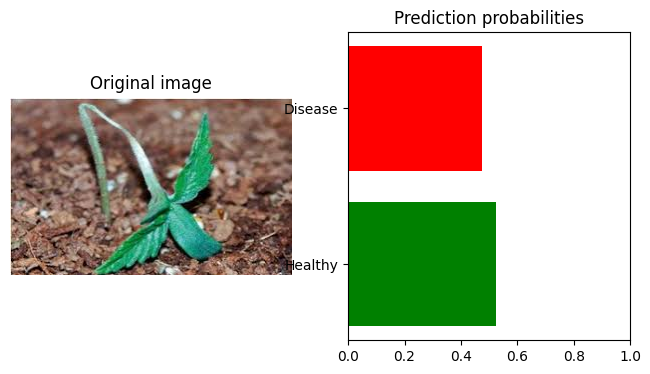

In [ ]:
import torch
import torch.nn as nn
import timm
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os
import random



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class WheatBinaryClassifier(nn.Module):
    def __init__(self):
        super().__init__()

        self.backbone = timm.create_model(
            "efficientnet_b0",
            pretrained=False,
            num_classes=0   
        )

        self.classifier = nn.Linear(
            self.backbone.num_features,
            1
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.classifier(x)
        return x


MODEL_PATH = "/kaggle/input/wheat-disease/wheat_efficientnet_b0.pth"

model = WheatBinaryClassifier()

state_dict = torch.load(
    MODEL_PATH,
    map_location=device
)

model.load_state_dict(state_dict)
model.to(device)
model.eval()


transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


def predict(image: Image.Image):
    image_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        logits = model(image_tensor)
        prob = torch.sigmoid(logits).item()

    return {
        "Healthy": 1 - prob,
        "Disease": prob
    }


TEST_DIR = "/kaggle/input/wheat-plant-diseases/data/test"

image_files = []

for root, _, files in os.walk(TEST_DIR):
    for file in files:
        if file.lower().endswith((".jpg", ".jpeg", ".png")):
            image_files.append(os.path.join(root, file))

print(f"Found {len(image_files)} images")

random_image_path = random.choice(image_files)
random_image_name = os.path.basename(random_image_path)

print("Random image:", random_image_name)

image = Image.open(random_image_path).convert("RGB")

result = predict(image)
print("Prediction:", result)




def visualize_prediction(image, probs):
    class_names = ["Healthy", "Disease"]

    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.axis("off")
    plt.title("Original image")

    plt.subplot(1, 2, 2)
    plt.barh(
        class_names,
        [probs["Healthy"], probs["Disease"]],
        color=["green", "red"]
    )
    plt.xlim(0, 1)
    plt.title("Prediction probabilities")

    plt.show()


visualize_prediction(image, result)
